<a href="https://colab.research.google.com/github/anushan1989/Waster_Segregation_CNN/blob/main/Anu_CNN_Waste_Segregation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Waste Material Segregation for Improving Waste Management


```
Objective

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

    Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
    Improve waste segregation efficiency to support recycling and reduce landfill waste.
    Understand the properties of different waste materials to optimise sorting methods for sustainability.

```



Data Understanding

The Dataset consists of images of some common waste materials.

    Food Waste
    Metal
    Paper
    Plastic
    Other
    Cardboard
    Glass




Data Description

    The dataset consists of multiple folders, each representing a specific class, such as Cardboard, Food_Waste, and Metal.
    Within each folder, there are images of objects that belong to that category.
    However, these items are not further subcategorised.
    For instance, the Food_Waste folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.



1. Load the data

Load and unzip the dataset zip file.


In [1]:
!pip install opencv-python
!pip install tensorflow

In [2]:
### Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os # Import the os module
import cv2
import sklearn
from PIL import Image as im
from glob import glob
from google.colab import drive
from sklearn.model_selection import train_test_split
import keras
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import zipfile # Import the zipfile module

In [3]:
from google.colab import drive
print(os.getcwd())
drive.mount('/content/drive')

/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Load the dataset.

In [4]:
# Load and unzip the dataset
# Assuming the dataset zip file is named 'waste_dataset.zip'
# Uncomment the following lines when working with the actual zip file

with zipfile.ZipFile('/content/drive/MyDrive/Colab_Notebooks/data.zip', 'r') as zip_ref:
    zip_ref.extractall('Garbage_classification')


In [5]:
# Path to the dataset directory
#dataset_path = 'Garbage_classification/data/Paper'  # Update this path as needed
import os
data_path = '/content/Garbage_classification/data'
os.listdir(data_path)

['Other', 'Glass', 'Cardboard', 'Food_Waste', 'Metal', 'Plastic', 'Paper']

In [6]:
BATCH_SIZE = 64
img_height = 128
img_width = 128

#2. Data Preparation [25 marks]

## 2.1 Load and Preprocess Images [8 marks]

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#2.1.1 [3 marks]

Create a function to load the images.

In [7]:
import tensorflow as tf
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split = 0.2,
    subset = 'training',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123,
    #Limit the number of training samples
    #labels = ['0', '1', '2', '3', '4', '5'][:2000] #Limit the number of labels to 2000)
)

Found 7625 files belonging to 7 classes.
Using 6100 files for training.


#2.1.2 [5 marks]

Load images and labels.

In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split = 0.2,
    subset = 'validation',
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = BATCH_SIZE,
    seed = 123)

Found 7625 files belonging to 7 classes.
Using 1525 files for validation.


In [9]:
class_names = train_ds.class_names
print(class_names)

['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


Perform any operations, if needed, on the images and labels to get them into the desired format.

#2.2 Data Visualisation [9 marks]

#2.2.1 [3 marks]

Create a bar plot to display the class distribution

#2.2.2 [3 marks]

Visualise some sample images

Text(0, 0.5, 'Number of Traingn images')

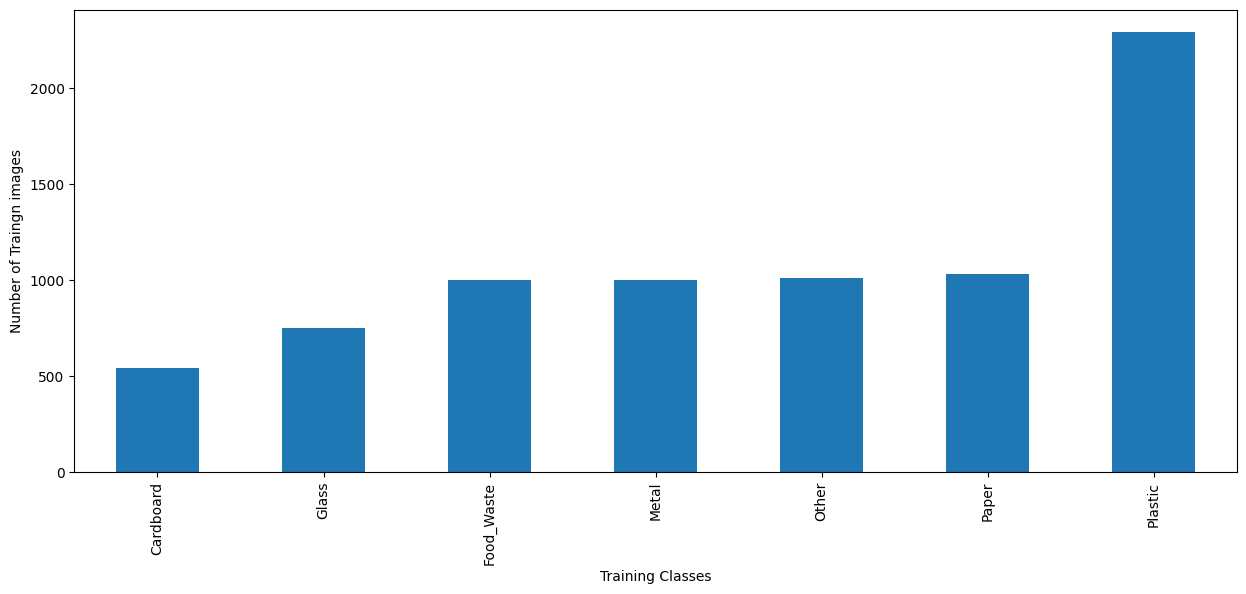

In [10]:
# Visualise Sample Images (across different labels)

# number of images in each class for training datasets
data_dic = {}
for folder in os.listdir(data_path):
    data_dic[folder] = len(os.listdir(data_path + '/' + folder))

data_df= pd.Series(data_dic)
plt.figure(figsize = (15, 6))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Training Classes')
plt.ylabel('Number of Traingn images')

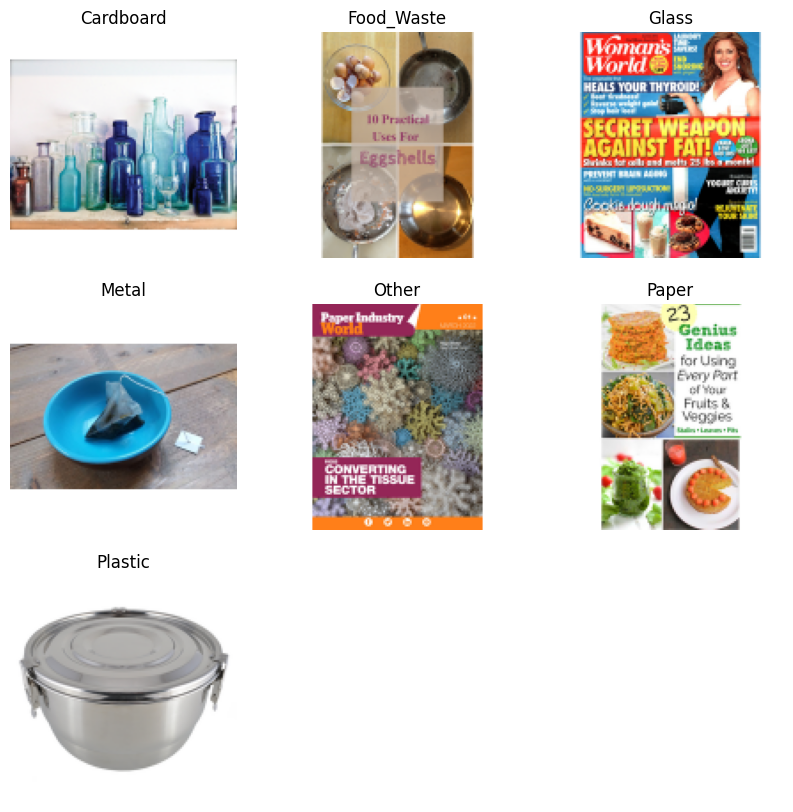

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(len(class_names)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

#2.2.3 [3 marks]

Based on the smallest and largest image dimensions, resize the images.

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential([
    #layers.CenterCrop(125, 125),
    layers.RandomFlip('horizontal', input_shape = (img_height, img_width, 3)),
    layers.RandomRotation(0.2, fill_mode = 'nearest'),
    layers.RandomZoom(0.1),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


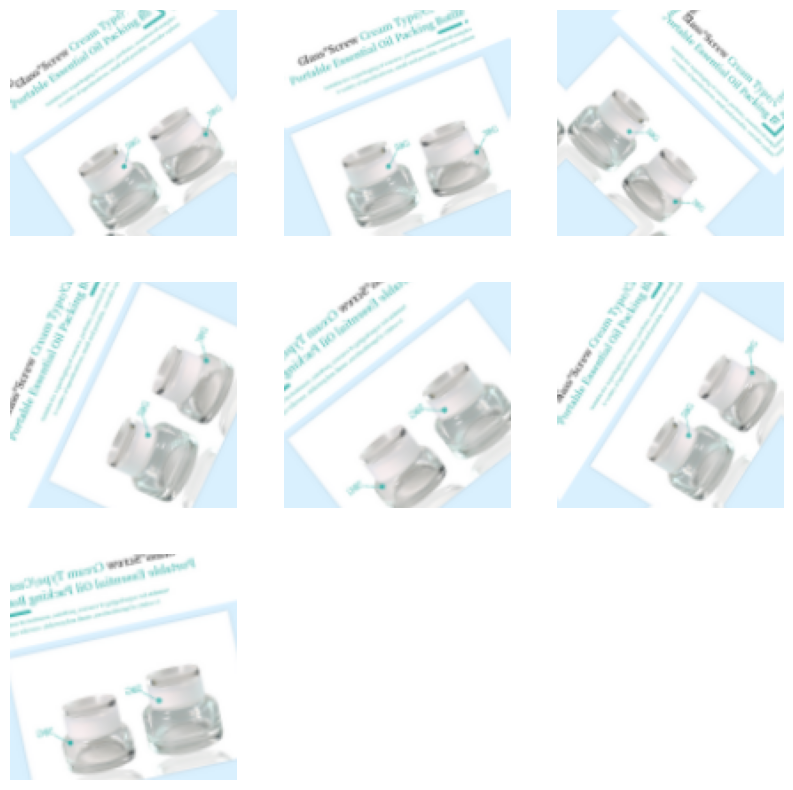

In [13]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(len(class_names)):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
   # plt.title(class_names[2])
    plt.axis("off")

In [14]:


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)



In [15]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')
#base_model.trainable = False
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
def print_layer_trainable():
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [17]:
print_layer_trainable()

True:	input_layer_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [18]:
# Unfreeze some layers of the base model
#base_model.trainable = True

2.3 Encoding the classes [3 marks]



There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.


In [19]:
base_model.trainable = False

for layer in base_model.layers:
    if 'block5' in layer.name or 'block4' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False



2.3.1 [3 marks]

Encode the target class labels.

In [20]:
n_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation = 'softmax')
])

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,255 (56.39 MB)

 Trainable params: 13,045,767 (49.77 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

#2.4 Data Splitting [5 marks]

2.4.1 [5 marks]

Split the dataset into training and validation sets

In [22]:
from tensorflow.keras import mixed_precision


train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size = AUTOTUNE)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])



#3. Model Building and Evaluation [20 marks]

3.1 Model building and training [15 marks]

In [23]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights.hdf5.keras', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, restore_best_weights = True, mode = 'min')

# Import ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau

# ReduceLROnPlateau
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 2,  # Reduced patience
                                verbose = 1, factor = 0.5, min_lr = 0.000001)

3.1.1 [10 marks]

Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [24]:


%%time
history = model.fit(train_ds,
                    epochs = 10,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.3298 - loss: 1.7579 - val_accuracy: 0.5613 - val_loss: 1.2508 - learning_rate: 1.0000e-04
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.5402 - loss: 1.2792 - val_accuracy: 0.5974 - val_loss: 1.0806 - learning_rate: 1.0000e-04
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6203 - loss: 1.0841 - val_accuracy: 0.6354 - val_loss: 1.0424 - learning_rate: 1.0000e-04
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.6676 - loss: 0.9698 - val_accuracy: 0.6741 - val_loss: 0.8977 - learning_rate: 1.0000e-04
Epoch 5/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.6928 - loss: 0.8794 - val_accuracy: 0.6774 - val_loss: 0.8896 - learning_rate: 1.0000e-04
Epoch 6/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.7469 - loss: 0.7573 - val_accuracy: 0.7154 - val_loss: 0.8305 - learning_rate: 1.0000e-04
Epoch 7/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.7523 

In [25]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 7625 files belonging to 7 classes.


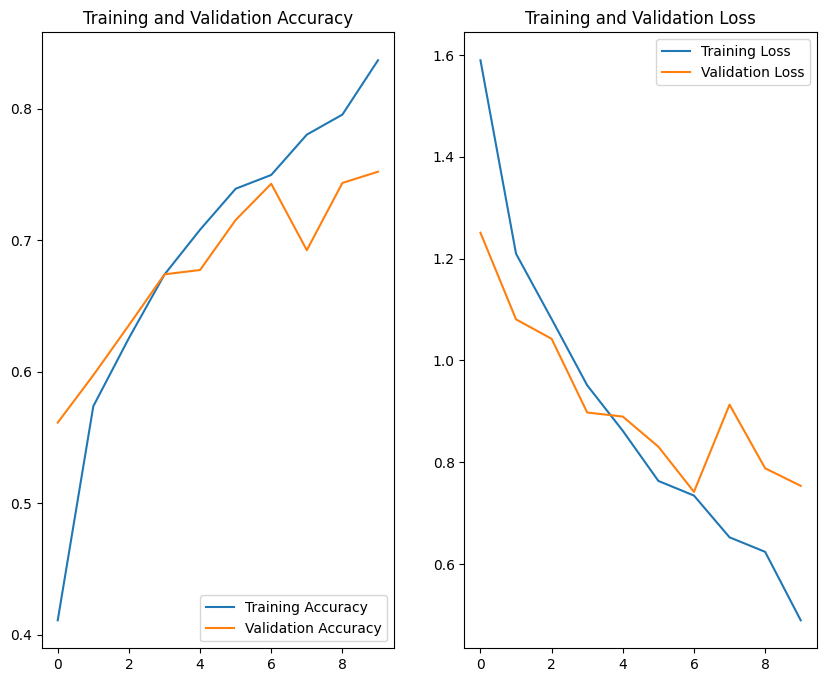

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize = (10, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 7625 files belonging to 7 classes.


In [28]:
import numpy as np

# Preprocess and store data (do this once)
def preprocess_and_store(dataset, filename):
  images, labels = [], []
  for batch_images, batch_labels in dataset:
    images.extend(batch_images.numpy())
    labels.extend(batch_labels.numpy())
  np.savez_compressed(filename, images=np.array(images), labels=np.array(labels))

preprocess_and_store(train_ds, 'train_data.npz')
preprocess_and_store(val_ds, 'val_data.npz')

# Load preprocessed data
def load_preprocessed_data(filename):
  data = np.load(filename)
  images, labels = data['images'], data['labels']
  dataset = tf.data.Dataset.from_tensor_slices((images, labels))
  return dataset.batch(BATCH_SIZE).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = load_preprocessed_data('train_data.npz')
val_ds = load_preprocessed_data('val_data.npz')



#3.1.2 [5 marks]

Train the model.

Use appropriate metrics and callbacks as needed.

In [29]:
# Generate predictions
model.load_weights('/content/vgg16_best_weights.hdf5.keras') # initialize the best trained weights
preds = model.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

7625/7625 ━━━━━━━━━━━━━━━━━━━━ 205s 27ms/step


In [30]:
model.evaluate(test_ds, verbose = 1)

7625/7625 ━━━━━━━━━━━━━━━━━━━━ 211s 28ms/step - accuracy: 0.8155 - loss: 0.5245


[0.56656813621521, 0.8049836158752441]

In [31]:
BATCH_SIZE = 64
img_height = 128
img_width = 128

import tensorflow as tf


def print_layer_trainable(): # Defining the function 'print_layer_trainable'
    for layer in base_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

IMG_SHAPE = (img_height, img_width, 3)
base_model = tf.keras.applications.VGG16(input_shape = IMG_SHAPE,
                                         include_top = False,
                                         weights = 'imagenet')


fine_tune  = base_model


fine_tune.trainable = True


for layer in fine_tune.layers:
    trainable = ('block5' in layer.name or 'block4' in layer.name or 'block3' in layer.name)
    layer.trainable = trainable




print_layer_trainable()



False:	input_layer_3
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [32]:


fine_tune.summary()



Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,454,528 (55.14 MB)

 Non-trainable params: 260,160 (1016.25 KB)

In [44]:
n_classes = len(class_names)

model2 = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    fine_tune,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation = 'relu',kernel_regularizer=tf.keras.regularizers.l2(0.01)), # Add L2 regularization
    layers.Dropout(0.7),
    layers.Dense(n_classes, activation = 'softmax')
])

In [45]:
model2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,781,255 (56.39 MB)

 Trainable params: 14,521,095 (55.39 MB)

 Non-trainable params: 260,160 (1016.25 KB)

In [47]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),  # Adjust learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [48]:
# Model Chackpoint
tl_checkpoint_1 = ModelCheckpoint(filepath = 'vgg16_best_weights_fine_tuning.hdf5.keras', save_best_only = True, verbose = 0)

# EarlyStopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True, mode = 'min')

# Import ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau

#ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.000001)


%time


In [49]:
%%time
history = model2.fit(train_ds,
                    epochs = 20,
                    validation_data = val_ds,
                    callbacks = [tl_checkpoint_1, early_stop, rop_callback])

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.1951 - loss: 3.9375 - val_accuracy: 0.3200 - val_loss: 3.3674 - learning_rate: 1.0000e-04
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.3216 - loss: 3.2646 - val_accuracy: 0.3528 - val_loss: 2.9380 - learning_rate: 1.0000e-04
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.3492 - loss: 2.8674 - val_accuracy: 0.3600 - val_loss: 2.6522 - learning_rate: 1.0000e-04
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.3627 - loss: 2.5671 - val_accuracy: 0.3646 - val_loss: 2.4007 - learning_rate: 1.0000e-04
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.3785 - loss: 2.3414 - val_accuracy: 0.3554 - val_loss: 2.2514 - learning_rate: 1.0000e-04
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.3929 - loss: 2.1489 - val_accuracy: 0.3692 - val_loss: 2.0817 - learning_rate: 1.0000e-04
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.4033 

#3.2 Model Testing and Evaluation [5 marks]

3.2.1 [5 marks]

Evaluate the model on test dataset. Derive appropriate metrics.

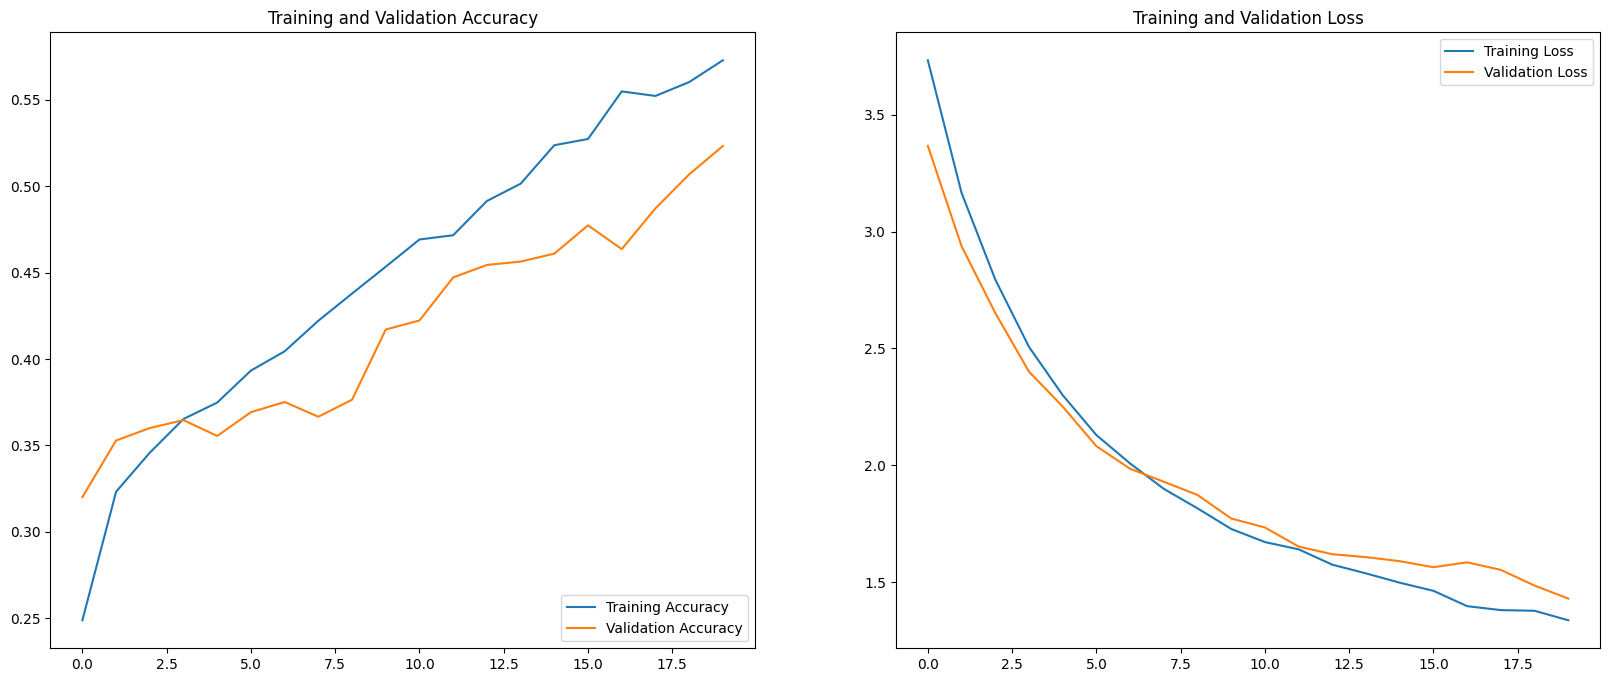

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:
AUTOTUNE = tf.data.AUTOTUNE # Define AUTOTUNE here using tf.data.AUTOTUNE

test_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    label_mode = 'categorical',
    image_size = (img_height, img_width),
    batch_size = 1,
    seed = 123)

test_ds = test_ds.cache().prefetch(buffer_size = AUTOTUNE)

Found 7625 files belonging to 7 classes.


In [52]:
# Generate predictions
model2.load_weights('/content/vgg16_best_weights_fine_tuning.hdf5.keras') # initialize the best trained weights
preds = model2.predict(test_ds)
pred_classes = np.argmax(preds, axis = 1)

7625/7625 ━━━━━━━━━━━━━━━━━━━━ 200s 26ms/step


In [53]:
model2.evaluate(test_ds, verbose = 1)

7625/7625 ━━━━━━━━━━━━━━━━━━━━ 208s 27ms/step - accuracy: 0.5735 - loss: 1.2940


[1.3343167304992676, 0.5589508414268494]

#5. Conclusions [5 marks]

5.1 Conclude with outcomes and insights gained [5 marks]

Model 1 : [0.56656813621521, 0.8049836158752441]

Model 2: [1.3343167304992676, 0.5589508414268494]

Accuracy On Transfer Learning : 13.34% Accuracy On Fine Tuning : 55.89%